In [1]:
import matplotlib.pyplot as plt

import numpy as np #importa a biblioteca usada para trabalhar com vetores e matrizes
import pandas as pd #importa a biblioteca usada para trabalhar com dataframes
import util

#importa o arquivo e extrai as features
Xfeatures, Y = util.extract_features('datasets/everything.csv')

In [2]:
import svmutil
from svmutil import svm_read_problem
from svmutil import svm_problem
from svmutil import svm_parameter
from svmutil import svm_train
from svmutil import svm_predict
from svmutil import svm_save_model


In [3]:
### Classificador - Kernel linear ###

# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
Xk, Yk = Xfeatures[idx_perm, :], Y[idx_perm]

# define a porcentagem de dados que irao compor o conjunto de treinamento
pTrain = 0.8 

# obtem os indices dos dados da particao de treinamento e da particao de teste
train_index, test_index = util.stratified_holdOut(Yk, pTrain)

X_train, X_test = Xk[train_index, :], Xk[test_index, :];
Y_train, Y_test = Yk[train_index], Yk[test_index];

train_index, val_index = util.stratified_holdOut(Y_train, pTrain)

Xtrain, Xvalid = X_train[train_index, :], X_train[val_index, :]
Ytrain, Yvalid = Y_train[train_index], Y_train[val_index]

print('Numero de dados de validação: %d' %(Xvalid.shape[0]))

# Treinamento:
custo = 26.0
kernel = 0 # kernel linear
model = svm_train(Ytrain, Xtrain, '-c %f -t %d' %(custo, kernel))

# Predição:
p_labs, p_acc, p_vals = svm_predict(Yvalid, Xvalid, model)

Numero de dados de validação: 444
Accuracy = 82.6577% (367/444) (classification)


In [4]:
def gridSearch(X, Y, Xval, Yval):
    """
    Retorna o melhor valor para os parâmetros custo e gamma do SVM radial.
    
    Parâmetros
    ----------
    X : matriz com os dados de treinamento
    
    y : vetor com classes de cada dados de treinamento
    
    Xval : matriz com os dados de validação
    
    yval : vetor com as classes dos dados de validação
    
    Retorno
    -------
    custo, gamma : os melhores valores para os parêmetros custo e gamma.
    
     """
    
    #inicializa as variáveis que deverão ser retornadas pela função
    custo = 1000
    gamma = 1000
    
    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # Complete esta função para retornar os melhores valores de C e gamma com base
    # nos dados do conjunto de validação.
    # Você pode usar a função svm_predict() para fazer a predição das classes das amostras do
    # conjunto de validação. 
    #
    # Importante
    # ----
    # Você pode calcular a acurácia usando
    # 
    #    acuracia = np.sum(classes==Yval)/len(Yval) 
    
    aux = [0.01,0.1,1,10,100]
    values = []
    acc = 0
    
    for i in range(1,9):
        for number in aux:
            values.append(i * number)
    values.sort()

    for aux_custo in values:
        for aux_gamma in values:

            kernel = 2 #kernel radial
            model = svm_train(Y, X, '-c %f -t %d -g %f -q' %(aux_custo, kernel, aux_gamma))
            p_labs, p_acc, p_vals = svm_predict(Yval, Xval, model)

            if(p_acc[0] > acc):
                acc = p_acc[0]
                custo = aux_custo
                gamma  = aux_gamma
    
    ##########################################################################

    return custo, gamma


#chama a função que faz a busca em grade
bestC, bestGamma = gridSearch(Xtrain, Ytrain, Xvalid, Yvalid)
    
print('Melhores parâmetros\nC: %1.3f, gamma=%1.3f' %(bestC,bestGamma))

Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52

Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52.2523% (232/444) (classification)
Accuracy = 52

Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 73.6486% (327/444) (classification)
Accuracy = 77.7027% (345/444) (classification)
Accuracy = 79.2793% (352/444) (classification)
Accuracy = 77.9279% (346/444) (classification)
Accuracy = 78.3784% (348/444) (classification)
Accuracy = 78.1532% (347/444) (classification)
Accuracy = 78.1532% (347/444) (classification)
Accuracy = 78.6036% (349/444) (classification)
Accuracy = 77.4775% (344/444) (classification)
Accuracy = 73.6486% (327/444) (classification)
Accuracy = 70.7207% (314/444) (classification)
Accuracy = 67

Accuracy = 81.7568% (363/444) (classification)
Accuracy = 82.2072% (365/444) (classification)
Accuracy = 81.982% (364/444) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 77.7027% (345/444) (classification)
Accuracy = 74.5495% (331/444) (classification)
Accuracy = 72.973% (324/444) (classification)
Accuracy = 70.4955% (313/444) (classification)
Accuracy = 68.4685% (304/444) (classification)
Accuracy = 65.5405% (291/444) (classification)
Accuracy = 64.6396% (287/444) (classification)
Accuracy = 64.1892% (285/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6

Accuracy = 55.8559% (248/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 84

Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 84.2342% (374/444) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 78.3784% (348/444) (classification)
Accuracy = 75.9009% (337/444) (classification)
Accuracy = 74.7748% (332/444) (classification)
Accuracy = 74.0991% (329/444) (classification)
Accuracy = 72.7477% (323/444) (classification)
Accuracy = 70.7207% (314/444) (classification)
Accuracy = 70

Accuracy = 78.3784% (348/444) (classification)
Accuracy = 75.9009% (337/444) (classification)
Accuracy = 74.7748% (332/444) (classification)
Accuracy = 74.0991% (329/444) (classification)
Accuracy = 72.7477% (323/444) (classification)
Accuracy = 70.7207% (314/444) (classification)
Accuracy = 70.7207% (314/444) (classification)
Accuracy = 60.1351% (267/444) (classification)
Accuracy = 57.6577% (256/444) (classification)
Accuracy = 57.6577% (256/444) (classification)
Accuracy = 55.8559% (248/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55

Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 84.009% (373/444) (classification)
Accuracy = 83.3333% (370/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 83.

Accuracy = 82.8829% (368/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 78.3784% (348/444) (classification)
Accuracy = 75.9009% (337/444) (classification)
Accuracy = 74.7748% (332/444) (classification)
Accuracy = 74.0991% (329/444) (classification)
Accuracy = 72.7477% (323/444) (classification)
Accuracy = 70.7207% (314/444) (classification)
Accuracy = 70.7207% (314/444) (classification)
Accuracy = 60.1351% (267/444) (classification)
Accuracy = 57.6577% (256/444) (classification)
Accuracy = 57.6577% (256/444) (classification)
Accuracy = 55.8559% (248/444) (classification)
Accuracy = 55

Accuracy = 70.7207% (314/444) (classification)
Accuracy = 70.7207% (314/444) (classification)
Accuracy = 60.1351% (267/444) (classification)
Accuracy = 57.6577% (256/444) (classification)
Accuracy = 57.6577% (256/444) (classification)
Accuracy = 55.8559% (248/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55.6306% (247/444) (classification)
Accuracy = 55

In [5]:
def imprimeRelatorio(p_acc, kernel):
    print('\n\tAccuracy \tErro quadratico   \tCoeficiente correlacao   \tKernel')
    print('\t%1.3f      \t%1.3f      \t%1.3f      \t%d' % (p_acc[0], p_acc[1], p_acc[2], kernel ) )
    
    print('\t------------------------------------------------')

In [6]:
### Classificador - Kernel radial ### 
# treina o classificador com o melhor custo e o melhor gamma encontrados 
# Treinamento e clasificacao com valores de kernel:

# 0 -- linear: u\'\*v
# 1 -- polynomial: (gamma\*u\'\*v + coef0)^degree
# 2 -- radial basis function: exp(-gamma\*|u-v|^2)
# 3 -- sigmoid: tanh(gamma\*u\'\*v + coef0)

print('\n-----------\nSVM Classificator: \n-----------\n')

kernel = 0
model = svm_train(Ytrain, Xtrain, '-c %f -t %d' %(bestC, kernel))

# Predição:
p_labs, p_acc, p_vals = svm_predict(Yvalid, Xvalid, model)

imprimeRelatorio(p_acc, kernel)

for kernel in range(1, 4):
    
    model = svm_train(Ytrain, Xtrain, '-q -c %f -t %d -g %f' %(bestC, kernel, bestGamma))

    p_labs, p_acc, p_vals = svm_predict(Yvalid, Xvalid, model)

    imprimeRelatorio(p_acc, kernel)
    


-----------
SVM Classificator: 
-----------

Accuracy = 81.5315% (362/444) (classification)

	Accuracy 	Erro quadratico   	Coeficiente correlacao   	Kernel
	81.532      	0.185      	0.398      	0
	------------------------------------------------
Accuracy = 63.5135% (282/444) (classification)

	Accuracy 	Erro quadratico   	Coeficiente correlacao   	Kernel
	63.514      	0.365      	0.131      	1
	------------------------------------------------
Accuracy = 84.9099% (377/444) (classification)

	Accuracy 	Erro quadratico   	Coeficiente correlacao   	Kernel
	84.910      	0.151      	0.487      	2
	------------------------------------------------
Accuracy = 84.4595% (375/444) (classification)

	Accuracy 	Erro quadratico   	Coeficiente correlacao   	Kernel
	84.459      	0.155      	0.476      	3
	------------------------------------------------


Accuracy = 100% (9/9) (classification)
Accuracy = 54.2793% (241/444) (classification)
Accuracy = 100% (10/10) (classification)
Accuracy = 52.7027% (234/444) (classification)
Accuracy = 100% (11/11) (classification)
Accuracy = 47.7477% (212/444) (classification)
Accuracy = 100% (12/12) (classification)
Accuracy = 48.1982% (214/444) (classification)
Accuracy = 100% (13/13) (classification)
Accuracy = 50.4505% (224/444) (classification)
Accuracy = 100% (14/14) (classification)
Accuracy = 54.2793% (241/444) (classification)
Accuracy = 100% (15/15) (classification)
Accuracy = 54.2793% (241/444) (classification)
Accuracy = 100% (16/16) (classification)
Accuracy = 53.6036% (238/444) (classification)
Accuracy = 100% (17/17) (classification)
Accuracy = 62.6126% (278/444) (classification)
Accuracy = 100% (18/18) (classification)
Accuracy = 56.3063% (250/444) (classification)
Accuracy = 100% (19/19) (classification)
Accuracy = 54.955% (244/444) (classification)
Accuracy = 100% (20/20) (classifica

Accuracy = 99.0476% (104/105) (classification)
Accuracy = 72.973% (324/444) (classification)
Accuracy = 99.0566% (105/106) (classification)
Accuracy = 72.7477% (323/444) (classification)
Accuracy = 99.0654% (106/107) (classification)
Accuracy = 73.4234% (326/444) (classification)
Accuracy = 99.0741% (107/108) (classification)
Accuracy = 73.4234% (326/444) (classification)
Accuracy = 99.0826% (108/109) (classification)
Accuracy = 72.5225% (322/444) (classification)
Accuracy = 99.0909% (109/110) (classification)
Accuracy = 72.973% (324/444) (classification)
Accuracy = 99.0991% (110/111) (classification)
Accuracy = 72.973% (324/444) (classification)
Accuracy = 99.1071% (111/112) (classification)
Accuracy = 73.4234% (326/444) (classification)
Accuracy = 99.115% (112/113) (classification)
Accuracy = 73.6486% (327/444) (classification)
Accuracy = 99.1228% (113/114) (classification)
Accuracy = 72.5225% (322/444) (classification)
Accuracy = 99.1304% (114/115) (classification)
Accuracy = 72.747

Accuracy = 98.4772% (194/197) (classification)
Accuracy = 77.4775% (344/444) (classification)
Accuracy = 98.4848% (195/198) (classification)
Accuracy = 77.4775% (344/444) (classification)
Accuracy = 98.4925% (196/199) (classification)
Accuracy = 77.2523% (343/444) (classification)
Accuracy = 98.5% (197/200) (classification)
Accuracy = 77.2523% (343/444) (classification)
Accuracy = 98.5075% (198/201) (classification)
Accuracy = 77.2523% (343/444) (classification)
Accuracy = 98.5149% (199/202) (classification)
Accuracy = 77.4775% (344/444) (classification)
Accuracy = 98.5222% (200/203) (classification)
Accuracy = 77.027% (342/444) (classification)
Accuracy = 98.5294% (201/204) (classification)
Accuracy = 77.4775% (344/444) (classification)
Accuracy = 98.5366% (202/205) (classification)
Accuracy = 77.2523% (343/444) (classification)
Accuracy = 98.5437% (203/206) (classification)
Accuracy = 77.2523% (343/444) (classification)
Accuracy = 98.5507% (204/207) (classification)
Accuracy = 77.252

Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.9167% (282/288) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.9239% (283/289) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 97.931% (284/290) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.9381% (285/291) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 97.9452% (286/292) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 97.9522% (287/293) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.9592% (288/294) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.9661% (289/295) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97.973% (290/296) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97.9798% (291/297) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97.986

Accuracy = 98.4% (369/375) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 98.4043% (370/376) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 98.4085% (371/377) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 98.4127% (372/378) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 98.4169% (373/379) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 98.4211% (374/380) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 98.4252% (375/381) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 98.4293% (376/382) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 98.4334% (377/383) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 98.4375% (378/384) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 98.4416% (379/385) (classification)
Accuracy = 80.85

Accuracy = 81.0811% (360/444) (classification)
Accuracy = 98.0603% (455/464) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.8495% (455/465) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 97.8541% (456/466) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 97.8587% (457/467) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.8632% (458/468) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.8678% (459/469) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.8723% (460/470) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.8769% (461/471) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.8814% (462/472) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.8858% (463/473) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97

Accuracy = 97.6407% (538/551) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97.6449% (539/552) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 97.6492% (540/553) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97.4729% (540/554) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97.4775% (541/555) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.482% (542/556) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.4865% (543/557) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.491% (544/558) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.4955% (545/559) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.5% (546/560) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.5045% (547/561) (classification)
Accuracy = 81.0811

Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.8701% (619/639) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.875% (620/640) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.8799% (621/641) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.8847% (622/642) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.8896% (623/643) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 97.3602% (627/644) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.3643% (628/645) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 97.3684% (629/646) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 97.3725% (630/647) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 97.3765% (631/648) (classification)
Accuracy = 80.4054% (357/444) (classification)
Accuracy = 97.3806% 

Accuracy = 97.1114% (706/727) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.1154% (707/728) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.1193% (708/729) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 96.9863% (708/730) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.9904% (709/731) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.9945% (710/732) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.9986% (711/733) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 97.0027% (712/734) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 97.0068% (713/735) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.0109% (714/736) (classification)
Accuracy = 80.1802% (356/444) (classification)
Accuracy = 97.0149% (715/737) (classification)
Accuracy = 79.955%

Accuracy = 96.4417% (786/815) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.4461% (787/816) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.4504% (788/817) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.4548% (789/818) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.4591% (790/819) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.4634% (791/820) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.5895% (793/821) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.5937% (794/822) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.5978% (795/823) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.6019% (796/824) (classification)
Accuracy = 79.955% (355/444) (classification)
Accuracy = 96.6061% (797/825) (classification)
Accuracy = 80.4054% (35

Accuracy = 97.01% (876/903) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 97.0133% (877/904) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.0166% (878/905) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.9095% (878/906) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.0232% (880/907) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.0264% (881/908) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 96.9197% (881/909) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 96.9231% (882/910) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 96.9265% (883/911) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 96.9298% (884/912) (classification)
Accuracy = 80.6306% (358/444) (classification)
Accuracy = 96.9332% (885/913) (classification)
Accuracy = 79.9

Accuracy = 96.9728% (961/991) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.9758% (962/992) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.9789% (963/993) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.9819% (964/994) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.9849% (965/995) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.988% (966/996) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.991% (967/997) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.994% (968/998) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 96.997% (969/999) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97% (970/1000) (classification)
Accuracy = 80.8559% (359/444) (classification)
Accuracy = 97.003% (971/1001) (classification)
Accuracy = 80.8559% (

Accuracy = 96.846% (1044/1078) (classification)
Accuracy = 81.7568% (363/444) (classification)
Accuracy = 96.8489% (1045/1079) (classification)
Accuracy = 81.7568% (363/444) (classification)
Accuracy = 96.8519% (1046/1080) (classification)
Accuracy = 81.7568% (363/444) (classification)
Accuracy = 96.8548% (1047/1081) (classification)
Accuracy = 81.7568% (363/444) (classification)
Accuracy = 96.9501% (1049/1082) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 96.9529% (1050/1083) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 96.9557% (1051/1084) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 96.9585% (1052/1085) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 96.9613% (1053/1086) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 96.9641% (1054/1087) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 96.9669% (1055/1088) (classifi

Accuracy = 97.1649% (1131/1164) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.1674% (1132/1165) (classification)
Accuracy = 81.0811% (360/444) (classification)
Accuracy = 97.2556% (1134/1166) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.2579% (1135/1167) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.2603% (1136/1168) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.2626% (1137/1169) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.265% (1138/1170) (classification)
Accuracy = 81.3063% (361/444) (classification)
Accuracy = 97.1819% (1138/1171) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 97.1843% (1139/1172) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 97.1867% (1140/1173) (classification)
Accuracy = 81.5315% (362/444) (classification)
Accuracy = 97.1891% (1141/1174) (classifi

Accuracy = 97.04% (1213/1250) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0424% (1214/1251) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0447% (1215/1252) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0471% (1216/1253) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0494% (1217/1254) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0518% (1218/1255) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0541% (1219/1256) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.136% (1221/1257) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0588% (1221/1258) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0612% (1222/1259) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.1429% (1224/1260) (classifica

Accuracy = 97.1557% (1298/1336) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 97.083% (1298/1337) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 97.0852% (1299/1338) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 97.0874% (1300/1339) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.1642% (1302/1340) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0917% (1302/1341) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.0939% (1303/1342) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.1705% (1305/1343) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.1726% (1306/1344) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.1747% (1307/1345) (classification)
Accuracy = 82.4324% (366/444) (classification)
Accuracy = 97.1768% (1308/1346) (classifi

Accuracy = 97.1167% (1381/1422) (classification)
Accuracy = 83.3333% (370/444) (classification)
Accuracy = 97.1188% (1382/1423) (classification)
Accuracy = 83.3333% (370/444) (classification)
Accuracy = 97.1208% (1383/1424) (classification)
Accuracy = 83.3333% (370/444) (classification)
Accuracy = 97.1228% (1384/1425) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 97.0547% (1384/1426) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 96.9867% (1384/1427) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 96.9888% (1385/1428) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 96.9909% (1386/1429) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 96.993% (1387/1430) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 96.9951% (1388/1431) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 96.9274% (1388/1432) (classifi

Accuracy = 96.817% (1460/1508) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.8191% (1461/1509) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.8212% (1462/1510) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.8233% (1463/1511) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.8254% (1464/1512) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.8275% (1465/1513) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.8296% (1466/1514) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.8317% (1467/1515) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.7678% (1467/1516) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.7699% (1468/1517) (classification)
Accuracy = 82.8829% (368/444) (classification)
Accuracy = 96.7721% (1469/1518) (classifi

Accuracy = 97.0514% (1547/1594) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 97.0533% (1548/1595) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 97.0551% (1549/1596) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 97.057% (1550/1597) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 97.0588% (1551/1598) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 97.0607% (1552/1599) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 97.0625% (1553/1600) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 97.0019% (1553/1601) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 97.0037% (1554/1602) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 97.0056% (1555/1603) (classification)
Accuracy = 83.1081% (369/444) (classification)
Accuracy = 97.0075% (1556/1604) (classifi

Accuracy = 97.0238% (1630/1680) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9661% (1630/1681) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9679% (1631/1682) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9697% (1632/1683) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9715% (1633/1684) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9139% (1633/1685) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9751% (1635/1686) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9769% (1636/1687) (classification)
Accuracy = 83.5586% (371/444) (classification)
Accuracy = 96.9787% (1637/1688) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 96.9213% (1637/1689) (classification)
Accuracy = 83.7838% (372/444) (classification)
Accuracy = 96.9822% (1639/1690) (classif

Accuracy = 96.8856% (1711/1766) (classification)
Accuracy = 84.9099% (377/444) (classification)
Accuracy = 96.8874% (1712/1767) (classification)
Accuracy = 84.9099% (377/444) (classification)
Accuracy = 96.8891% (1713/1768) (classification)
Accuracy = 84.9099% (377/444) (classification)
Accuracy = 96.8909% (1714/1769) (classification)
Accuracy = 84.9099% (377/444) (classification)
Accuracy = 96.8927% (1715/1770) (classification)
Accuracy = 84.9099% (377/444) (classification)
Accuracy = 96.8379% (1715/1771) (classification)
Accuracy = 85.1351% (378/444) (classification)


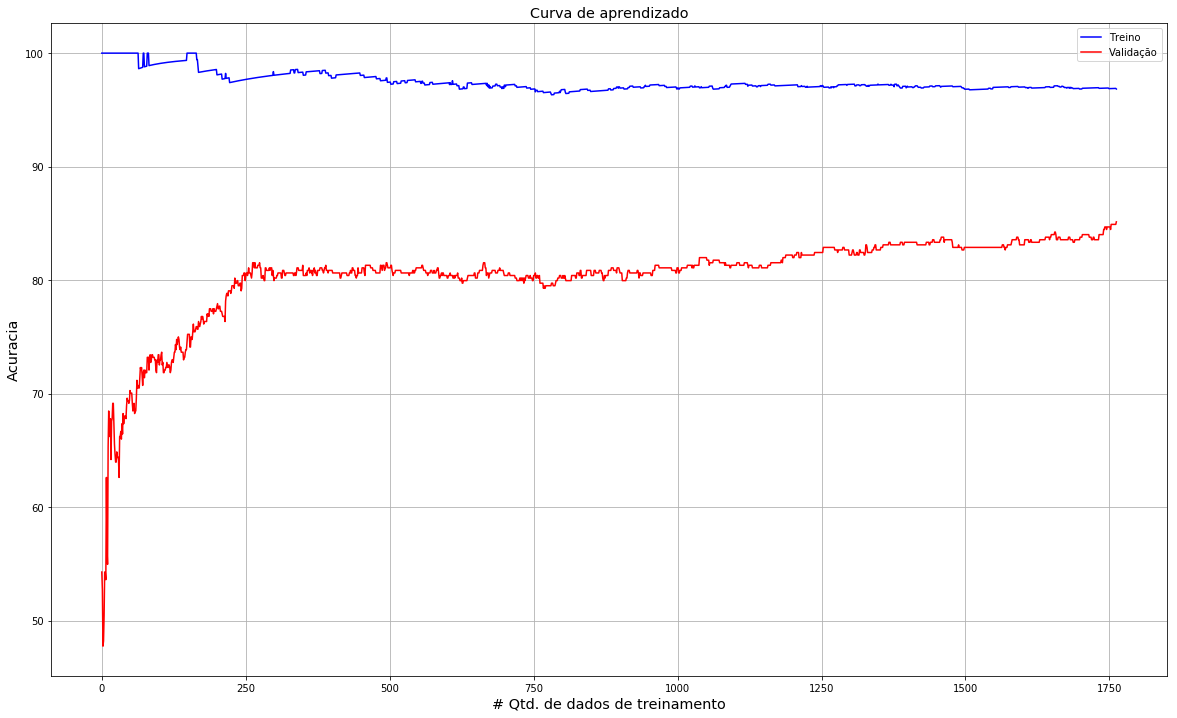

In [7]:
def curva_aprendizado(Xtrain, Ytrain, Xvalid, Yvalid, Cost, Gamma):
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
  
    """

    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # inicializa o parametro de regularizacao da regressao logistica
    lambda_reg = 1
        
    # Configura o numero de interacaoes da regressao logistica
    iteracoes = 500
        
    # Kernel radial
    kernel = 2
    
    ########################## COMPLETE O CÓDIGO AQUI  ###############################
    #  Instrucoes: Complete o codigo para gerar o gráfico da curva de aprendizado.
    #           Comece o treinamento com as primeiras 10 amostras da base de dados de 
    #           treinamento e calcule a acuracia do classificador tanto nos dados de
    #           treinamento já apresentados, quando na base de validacao. 
    #           Depois disso, adicione mais um dado para treinamento e calcule novamente 
    #           o desempenho. Continue adicionando um dado por vez ate todos os dados de 
    #           treinamento serem usados. Nas listas perf_train e perf_val, guarde a acuracia 
    #           obtida nos dados de treinamento e na base de validacao a cada nova adicao de 
    #           dados para treinamento.
    for idx, i in enumerate(np.arange(9, len(Xtrain) - 1)):
        model = svm_train(Ytrain[:i], Xtrain[:i, :], '-q -c %f -t %d -g %f' %(bestC, kernel, bestGamma))
        
        # Teste
        p_labs, p_acc, p_vals = svm_predict(Ytrain[:i], Xtrain[:i, :], model)
        perf_train.append(p_acc[0])
        
        # Validação
        p_labs, p_acc, p_vals = svm_predict(Yvalid, Xvalid, model)
        perf_val.append(p_acc[0])
    
    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()
    
curva_aprendizado(Xtrain, Ytrain, Xvalid, Yvalid, bestC, bestGamma)